In [1]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')
import re
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/habkaffee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# dataset = pd.read_csv('data/DATASET.csv')
# dataset

# Preprocessing

In [3]:
exclude_symbols = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                            '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                            '\x7f', '\xad', '¤', '\xa0', '\u200b', '–']) + string.punctuation
regex_symb = re.compile('[%s]' % re.escape(exclude_symbols))

In [4]:
stop_words = stopwords.words('english')
pattern = r'\b(?:' + '|'.join(stop_words) + r')\b'
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [5]:
tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [6]:
# def lemmatize_sentence(sentence):
#     if isinstance(sentence, str):
#       sentence = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(sentence)]
#     return sentence

In [7]:
dataset = pd.read_csv('data/DATASET.csv')

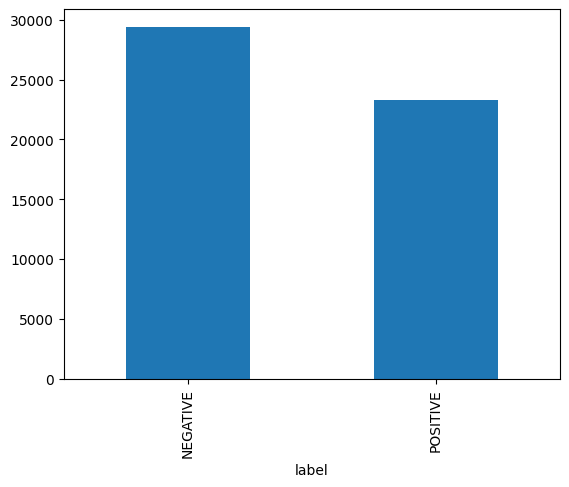

In [8]:
plt.figure()
dataset['label'].value_counts().plot.bar()
plt.show()

In [9]:
dataset['Review'] = dataset['Review'].str.lower()
dataset = dataset.loc[dataset['Review'].apply(lambda x: isinstance(x, str) and x.isascii())]
dataset['label'] = dataset['label'].str.replace('POSITIVE', '1').replace('NEGATIVE', '0')
dataset['Review'] = dataset['Review'].str.replace(pattern, '', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[{string.punctuation}]+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(r'\s+', ' ', regex=True)
dataset['Review'] = dataset['Review'].str.replace(f'[0-9]+', '', regex=True)

dataset['Review'] = dataset['Review'].apply(lambda sentence : tokenizer.tokenize(sentence))
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='n') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='v') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='a') for word in sentence])
dataset['Review'] = dataset['Review'].apply(lambda sentence : [lemmatizer.lemmatize(word, pos='r') for word in sentence])
# dataset['Review'] = dataset['Review'].apply(lambda sentence : ' '.join(sentence))
dataset

,Review,label
0,"[great, music, service, audio, high, quality, ...",1
1,"[please, ignore, previous, negative, rat, app,...",1
2,"[pop, get, best, spotify, experience, android,...",0
3,"[really, buggy, terrible, use, recently]",0
4,"[dear, spotify, get, song, put, playlist, shuf...",0
...,...,...
52697,"[yes, best]",1
52698,"[spotify, heart, feb, heart, music, lyric, lan...",1
52699,"[try, open, app, wont, open, restart, phone, i...",1
52700,[good],1


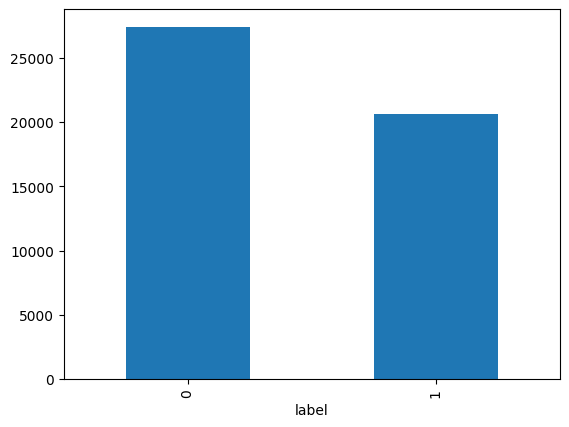

In [10]:
plt.figure()
dataset['label'].value_counts().plot.bar()
plt.show()

In [11]:
X, Y = dataset['Review'], dataset['label']

In [12]:
X.head()

0    [great, music, service, audio, high, quality, ...
1    [please, ignore, previous, negative, rat, app,...
2    [pop, get, best, spotify, experience, android,...
3             [really, buggy, terrible, use, recently]
4    [dear, spotify, get, song, put, playlist, shuf...
Name: Review, dtype: object

In [13]:
Y.head()

0    1
1    1
2    0
3    0
4    0
Name: label, dtype: object

In [14]:
all_words = set()
for data in X:
    all_words.update(data)
pd.DataFrame(all_words).T

,0,1,2,3,4,5,6,7,8,9,...,15392,15393,15394,15395,15396,15397,15398,15399,15400,15401
0,unjoyable,decentralize,recall,arse,ymusic,detriment,lagy,ablibale,alignment,convinence,...,inexplicably,teddy,shirs,safety,alcohol,turn,brazil,convenient,tivi,equipment


In [15]:
len(all_words)

15402

In [16]:
vectorizer = Word2Vec(X, vector_size=100, workers=4, min_count=3)
seed = 42

In [17]:
vectorizer.wv['app']

array([ 0.10536017,  0.547176  ,  0.63276494,  0.97949237, -0.61711466,
       -1.1126467 , -0.80728453,  0.57098347, -0.6087399 , -0.27667913,
        0.60858184,  0.0554064 ,  0.23331912,  1.1489247 ,  0.2811136 ,
       -0.5137241 , -0.26404813, -0.20003842, -0.26611796, -0.13732074,
        1.372958  ,  0.1413675 ,  0.28054318,  0.02526956,  0.84536356,
        0.6693484 ,  0.42038402,  0.33119205, -1.0771605 ,  0.25954878,
       -0.06304349, -0.26211056,  0.50501174, -0.70697093,  0.5199337 ,
        0.20484515,  0.16485767, -0.50330746,  0.7254726 , -0.42915034,
       -0.96152943,  0.5076901 , -0.22321749,  0.35643643,  0.32627803,
       -0.3859366 , -0.2873841 ,  0.6395373 ,  1.4981408 , -0.50445503,
        0.3656477 ,  1.0397642 , -0.45348457, -0.5295944 ,  1.8134247 ,
       -0.58779263,  0.4546917 ,  0.05103473,  0.3394081 , -0.16647433,
       -0.10019445,  0.33233833, -0.37137982, -1.0427266 , -0.38052183,
        0.04347824,  0.16496907,  0.85731226, -0.21699913, -1.11

In [18]:
def sentence_to_vector(sentence, model, vector_size):
    # Filter out words that are not in the model vocabulary
    words = [word for word in sentence if word in model.wv]
    if not words:
        return np.zeros(vector_size)  # Return a zero vector if no words in the model
    return np.mean([model.wv[word] for word in words], axis=0)

X_vectors = np.array([sentence_to_vector(sentence, vectorizer, 100) for sentence in X])

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_vectors, Y.astype(np.int8), test_size=0.25, random_state=seed)

# ML algs

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
def get_gridsearch_for_model(model, parameters : dict) -> GridSearchCV:
    model_grid = GridSearchCV(
        estimator=model,
        param_grid=parameters,
        scoring=['f1_micro', 'accuracy', 'recall_macro'],
        refit='f1_micro',
        cv=5,
        verbose=2,
        error_score=0,
        n_jobs=4
    )
    return model_grid

def print_grid_search_info(model):
    print(f'Best estimator -> {model.best_estimator_}\n\
Best Score -> {model.best_score_}\n\
Best Parameters -> {model.best_params_}\n\
Best index -> {model.best_index_}')


def print_metrics(y_test, y_pred):
    print(f'accuracy_score = {accuracy_score(y_test, y_pred)}\nf1_micro = {f1_score(y_test, y_pred, average="micro")}\nrecall_score = {recall_score(y_test, y_pred, average="macro")}\nprecision_score = {precision_score(y_test, y_pred, average="macro")}')


def display_conf_matrix(y_true, y_pred, Y):
    conf_matrix = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=Y.unique())
    cm_display.plot()
    plt.show()

In [22]:
parameters_logreg = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.5, 1.0, 10.0],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

grid_log = get_gridsearch_for_model(LogisticRegression(), parameters_logreg)

grid_log.fit(X_train, Y_train)
print_grid_search_info(grid_log)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=0.01, max_iter=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END .C=0.01, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.2s
[CV] END .....C=0.01, max_iter=100, penalty=l2,

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.6s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=1.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.6s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.5s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.1s
[CV] END ..C=1.0, max_iter=100, penalty=l1, solver=liblinear; total time=  17.2s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......C=1.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   2.0s
[CV] END ..C=1.0, max_iter=100, penalty=l2, solver=liblinear; total time=   1.9s
[CV] END ..C=1.0, max_iter=1

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.6s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=10.0, max_iter=100, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END .C=10.0, max_iter=100, penalty=l1, solver=liblinear; total time=  39.7s
[CV] END .C=10.0, max_iter=100, penalty=l1, solver=liblinear; total time=  50.2s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.4s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.7s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .....C=10.0, max_iter=500, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .C=10.0, max_iter=100, penalty=l2, solver=liblinear; total time=   4.9s
[CV] END .C=10.0, max_iter=1

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best estimator -> LogisticRegression(C=10.0, solver='liblinear')
Best Score -> 0.860887656033287
Best Parameters -> {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best index -> 51


In [23]:
Y_pred_logreg = grid_log.predict(X_test)
print_metrics(Y_test, Y_pred_logreg)
# save_model('./models/log_reg_trash.pkl', grid_log)

accuracy_score = 0.8607805608720979
f1_micro = 0.8607805608720979
recall_score = 0.8542500010603689
precision_score = 0.8603927603568766


In [24]:
parameters_linSVC = {
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'C': np.linspace(0.001, 0.1, 7),
    'max_iter': [1000, 3000, 5000],
    'dual':[True]
}

grid_linearSVC = get_gridsearch_for_model(LinearSVC(), parameters_linSVC)

grid_linearSVC.fit(X_train, Y_train)
print_grid_search_info(grid_linearSVC)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.1s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.1s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.1s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.001, dual=True, loss=hinge, max_iter=3000, penalty=l1; 

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.1s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.1s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0175, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.6s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0175, dual=True, loss

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.9s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.9s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   0.9s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   0.9s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.5s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.034, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   0.9s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.7s
[CV] END C=0.0505, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time= 

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.2s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.2s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0505, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.4s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.067, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.7s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.6s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.5s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.067, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.0835, dual=True, lo

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.9s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.9s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.8s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.8s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   1.8s
[CV] END C=0.0835, dual=True, loss=squared_hinge

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   2.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=1000, penalty=l2; total time=   0.2s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.0835, dual=True, loss=squared_hinge, max_iter=5000, penalty=l2; total time=   1.9s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=3000, penalty=l2; total time=   0.6s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.3s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.6s
[CV] END C=0.1, dual=True, loss=hinge, max_iter=5000, penalty=l2; total time=   0.4s


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   2.1s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   2.2s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   2.2s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s

[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l1; total time=   0.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=l2; total time=   2.2s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=3000, penalty=l2; total time=   2.0s
[CV] END C=0.1, dual=True, loss=squared_hinge, max_iter=1000, penalty=

/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best estimator -> LinearSVC(C=0.0835, dual=True, loss='hinge')
Best Score -> 0.8600832177531208
Best Parameters -> {'C': 0.0835, 'dual': True, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best index -> 61


/home/habkaffee/programming/nlp/nlp_classification/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [25]:
Y_pred_linSVC = grid_linearSVC.predict(X_test)
print_metrics(Y_test, Y_pred_linSVC)

accuracy_score = 0.8584505284180743
f1_micro = 0.8584505284180743
recall_score = 0.8514101775623109
precision_score = 0.8584256207132889


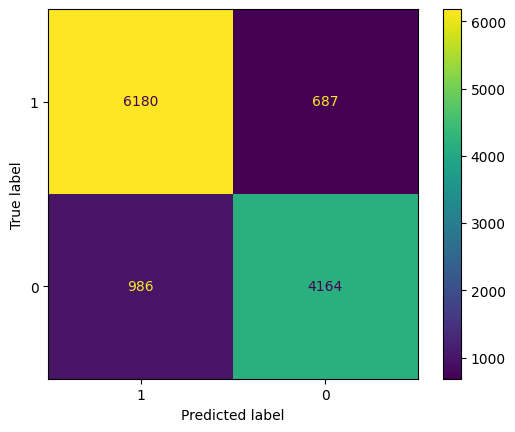

In [26]:
display_conf_matrix(Y_test, Y_pred_logreg, Y)

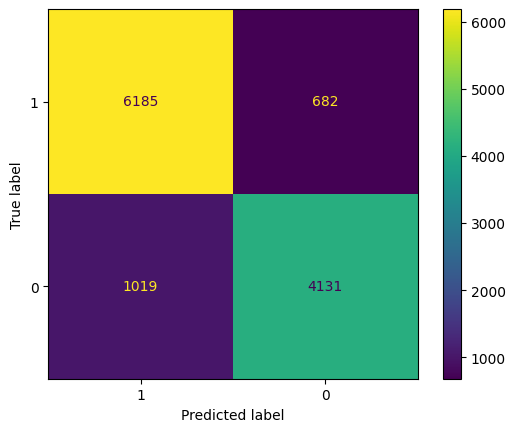

In [27]:
display_conf_matrix(Y_test, Y_pred_linSVC, Y)

# NN Models

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

class FC_binary(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.activation(out)
        return out

In [29]:
vector_size = 100
hidden_dim = 64
output_dim = 1
learning_rate = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Used device -> {device}')

fc_bin = FC_binary(vector_size, hidden_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(fc_bin.parameters(), lr=learning_rate)

Used device -> cuda


In [30]:
X_train_nn = torch.tensor(X_train, dtype=torch.float32)
X_test_nn = torch.tensor(X_test, dtype=torch.float32)
Y_train_nn = torch.tensor(Y_train.to_numpy(), dtype=torch.float32)
Y_test_nn = torch.tensor(Y_test.to_numpy(), dtype=torch.float32)

In [31]:
fc_bin.to(device=device)
# X_train_nn.to(device=device)
# X_test_nn.to(device=device)
# Y_train_nn.to(device=device)
# Y_test_nn.to(device=device)

FC_binary(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (activation): Sigmoid()
)

In [32]:
num_epochs = 100
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train_nn, Y_train_nn)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [33]:
for epoch in range(num_epochs):
    fc_bin.train()
    total_loss = 0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device=device)
        Y_batch = Y_batch.to(device=device)
        
        outputs = fc_bin(X_batch).squeeze(1)  # Remove extra dimension
        loss = criterion(outputs, Y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


Epoch 1/100, Loss: 0.3609758638698333
Epoch 2/100, Loss: 0.33393566252229057
Epoch 3/100, Loss: 0.3262814036781215
Epoch 4/100, Loss: 0.3216193122351286
Epoch 5/100, Loss: 0.31818001140189994
Epoch 6/100, Loss: 0.3157427337453655
Epoch 7/100, Loss: 0.31395760052296157
Epoch 8/100, Loss: 0.31231893205018624
Epoch 9/100, Loss: 0.3098111754446931
Epoch 10/100, Loss: 0.30919424778291793
Epoch 11/100, Loss: 0.30697022595284995
Epoch 12/100, Loss: 0.3062589261499039
Epoch 13/100, Loss: 0.3047743094580937
Epoch 14/100, Loss: 0.30301809007468855
Epoch 15/100, Loss: 0.3021037261850451
Epoch 16/100, Loss: 0.3015234100350576
Epoch 17/100, Loss: 0.29991384376147834
Epoch 18/100, Loss: 0.2990611292877976
Epoch 19/100, Loss: 0.2983509696616784
Epoch 20/100, Loss: 0.2971603934584514
Epoch 21/100, Loss: 0.29640815815266086
Epoch 22/100, Loss: 0.29533214957024423
Epoch 23/100, Loss: 0.2950865461589387
Epoch 24/100, Loss: 0.2941744752367091
Epoch 25/100, Loss: 0.29330057608494214
Epoch 26/100, Loss: 0.2

In [34]:
fc_bin.eval()
X_test_nn = X_test_nn.to(device=device)
Y_test_nn = Y_test_nn.to(device=device)
with torch.no_grad():
    outputs = fc_bin(X_test_nn).squeeze(1)
    predictions = (outputs > 0.5).float()  # Convert probabilities to 0 or 1
    accuracy = (predictions == Y_test_nn).float().mean()
    print(f'Test Accuracy: {accuracy:.8f}')


Test Accuracy: 0.86053091
